# Table of Contents
* [detections](#detections)
	* [define test ents](#define-test-ents)
	* [code](#code)
	* [run](#run)
* [run segmentation tests](#run-segmentation-tests)


In [17]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this
from anigen_tools.trajectory_viz import filter_chars, filter_description
from anigen_tools.trajectory_viz import avg_video_appearance
from anigen_tools.trajectory_viz import draw_trajectory_set
from anigen_tools.trajectory_viz import vid_filter

In [2]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [3]:
dataset = unpickle_this('../build_dataset/complete_ds_checkpoint_v2p8_cleaned.pkl')

In [4]:
with open('../build_dataset/first_sample_ids.txt', 'r') as f:
    sample_ids = [l.strip() for l in f.readlines()]

In [18]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def get_entitity(eid, dataset=dataset):
    vid = get_vid_from_eid(eid)
    video = get_vid(vid, dataset)
    all_vid_ents = video.data()['characters'] + video.data()['objects']
    return [ent for ent in all_vid_ents if ent.gid() == eid][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# detections

## define test ents

In [22]:
# not genuine motion
ngms = [get_entitity('s_06_e_20_shot_020293_020367_char_0'), 
        get_entitity('s_05_e_11_shot_012430_012504_char_1'),
        get_entitity('s_06_e_20_shot_010941_011015_char_1'), 
        get_entitity('s_06_e_04_shot_015079_015153_char_1'), 
        get_entitity('s_02_e_12_shot_015352_015426_char_0'),
        get_entitity('s_01_e_04_shot_009548_009622_char_0'),
        get_entitity('s_05_e_24_shot_003443_003517_char_0'),
        get_entitity('s_04_e_02_shot_034648_034722_char_0'),
        get_entitity('s_02_e_30_shot_003848_003922_char_0')
       ]

# genuine motion
gms = [get_entitity('s_01_e_08_shot_001903_001977_char_0'),
    get_entitity('s_02_e_14_shot_023305_023379_char_0'),
    get_entitity('s_06_e_04_shot_015356_015430_char_0'),
    get_entitity('s_03_e_01_shot_005846_005920_char_0'),
    get_entitity('s_02_e_31_shot_021011_021085_mustache_1_5'),
    get_entitity('s_03_e_17_shot_025762_025836_char_0'), 
    get_entitity('s_02_e_02_shot_012375_012449_char_0'),
   get_entitity('s_02_e_14_shot_043347_043421_char_0')
]

# slight_motion
sm = [get_entitity('s_01_e_16_shot_022209_022283_char_0')]

## code

In [23]:
from anigen_tools.hybrid_segmentation import get_ent_tracking
from anigen_tools.hybrid_segmentation import get_vid_frame_data
from anigen_tools.bboxes import comp_boxes_iou
from anigen_tools.interpolation import get_vid_from_eid
from anigen_tools.bboxes import comp_box_center, box_area

from anigen_tools.bboxes import nms
from anigen_tools.bboxes import prep_boxes_v2

In [458]:
# def detect_ent_movement_mean_comp(ent):
#     test_ent_track = get_ent_tracking(ent)
#     box_centers = np.apply_along_axis(comp_box_center, 1, test_ent_track)
#     return max(box_centers[:, 0]) - min(box_centers[:, 0]), max(box_centers[:, 1]) - min(box_centers[:, 1])
# #     box_areas = pd.Series(np.apply_along_axis(box_area, 1, test_ent_track))
# #     return box_areas.std() / box_areas.mean()
# #     mean_box = test_ent_track.mean(axis=0)
# #     iou_w_prev_frame = np.array([comp_boxes_iou(test_ent_track[fn], mean_box) for fn in range(0, test_ent_track.shape[0])])
# #     return np.mean(iou_w_prev_frame)

# def detect_ent_movement_dist(ent):
#     test_ent_track = get_ent_tracking(ent)
#     box_centers = np.apply_along_axis(comp_box_center, 1, test_ent_track)
#     ent_centroid = comp_centroid(box_centers)
#     centroid_dists = np.apply_along_axis(np.linalg.norm, 1, box_centers - ent_centroid)
#     return centroid_dists.sum() / (centroid_dists.shape[0] - 2)

In [24]:
def compare_flm_frames(ent):
    fr, mr, lr = np.array(ent.rect())
    fmc = comp_boxes_iou(fr, mr)
    return fmc


def detect_ent_movement_mean_comp(ent):
    test_ent_track = get_ent_tracking(ent)
    mean_box = test_ent_track.mean(axis=0)
    iou_w_prev_frame = np.array([comp_boxes_iou(test_ent_track[fn], mean_box) for fn in range(0, test_ent_track.shape[0])])
    return np.mean(iou_w_prev_frame)


def detect_ent_movement(ent):
    test_ent_track = get_ent_tracking(ent)
    iou_w_prev_frame = np.array([comp_boxes_iou(test_ent_track[fn], test_ent_track[fn + 1]) for fn in range(0, test_ent_track.shape[0] -1)])
    return np.mean(iou_w_prev_frame)


def comp_centroid(box_centers):
    return box_centers.sum(axis=0) / box_centers.shape[0]

In [26]:
def detect_movement_bounders(ent, motion_thresh=15):
    test_ent_track = get_ent_tracking(ent)
    lbx = test_ent_track[:, 0].std() 
    lby = test_ent_track[:, 1].std() 
    ubx = test_ent_track[:, 2].std() 
    uby = test_ent_track[:, 3].std()
    coord_points = np.array([lbx, ubx, lby, uby])
    if coord_points[:2].max() > 45:
        return True
    if coord_points[:2].max() > 25 and min(coord_points[:2]) < 20:
        return True
    return False

In [32]:
# tent = ngms[-2]
# test_ent_track = get_ent_tracking(tent)

# detect_movement_bounders(tent)

In [27]:
# [detect_movement_bounders(test_ent) for test_ent in ngms]

In [28]:
# [detect_ent_movement_mean_comp (test_ent) for test_ent in ngms]

In [29]:
# [detect_movement_bounders (test_ent) for test_ent in gms]

In [30]:
# [detect_movement_bounders (test_ent) for test_ent in gms]

In [31]:
# [detect_movement_bounders(test_ent) for test_ent in sm]

## run

In [34]:
definite_nonmovers = set(['roof', 'floor', 'ground', 'wall'])

In [38]:
characters_move = {}
for vid in tqdm(dataset):
    for vent in vid.data()['characters']:
        characters_move[vent.gid()] = detect_movement_bounders(vent)

100%|██████████| 26160/26160 [00:37<00:00, 689.82it/s]


In [40]:
objects_move = {}
for vid in tqdm(dataset):
    for vent in vid.data()['objects']:
        if vent.data()['entityLabel'].lower().strip() in definite_nonmovers:
            objects_move[vent.gid()] = False
        else:
            objects_move[vent.gid()] = detect_movement_bounders(vent)

100%|██████████| 26160/26160 [00:20<00:00, 1251.81it/s]


In [41]:
all_char_moves = pd.Series(characters_move)
all_obj_moves = pd.Series(objects_move)

In [43]:
print(all_char_moves.mean(), all_obj_moves.mean())

0.13547118680092457 0.13863253350453414


In [44]:
movers_df = pd.DataFrame(all_char_moves).append(pd.DataFrame(all_obj_moves))
movers_df['eid'] = movers_df.index
movers_df['vid'] = movers_df['eid'].apply(get_vid_from_eid)

In [45]:
# nonmovers_df = pd.DataFrame(all_char_ious[(all_char_ious > movers_thresh)]).append(pd.DataFrame(all_obj_ious[(all_obj_ious > movers_thresh)]))
# nonmovers_df['eid'] = nonmovers_df.index
# nonmovers_df['vid'] = nonmovers_df['eid'].apply(get_vid_from_eid)

In [46]:
movers_df.shape

(62561, 3)

In [37]:
# row_n = random.randint(0, movers_df.shape[0])
# movers_df.iloc[row_n]

# vid_to_viz = movers_df['vid'][row_n]
# vid = get_vid(vid_to_viz)
# # vid.display_gif()

# vid_to_viz = movers_df['vid'][row_n]
# vid = get_vid(vid_to_viz)
# # vid.display_gif()

# row_n = random.randint(0, nonmovers_df.shape[0])
# teid = nonmovers_df.iloc[row_n]['eid']
# nonmovers_df.iloc[row_n]

In [47]:
def select_ent_static_rect_nms(eid):
    ent = get_entitity(eid)
    frame_rects = ent.rect()
    if sum(bool(l) for l in frame_rects) !=3 :
        return None
    s_boxes, dupe_boxes, all_boxes = nms(frame_rects, 0.5, prep_boxes_v2)
    print(s_boxes)
    print(dupe_boxes)
    sorted_boxes = sorted(s_boxes, key=lambda x: x['votes'], reverse=True)
    best_box = sorted_boxes[0]
    if best_box['votes'] > 1:
        return best_box['box']
    else:
        return None

    
def select_ent_static_rect_mid(eid):
    ent = get_entitity(eid)
    frame_rects = ent.rect()
    if sum(bool(l) for l in frame_rects) !=3 :
        return None
    sorted_boxes = sorted(frame_rects, key=lambda x: box_area(np.array(x).reshape(2, 2)))
    best_box = sorted_boxes[1]
    return best_box

In [64]:
all_sample = movers_df
nonmovers_df_sample = all_sample[~all_sample[0]]
movers_df_sample = all_sample[all_sample[0]]

In [65]:
movers_df_sample.shape

(8554, 3)

In [66]:
nonmovers_df_sample.shape

(54007, 3)

In [67]:
%%time
nonmovers_df_sample['rects'] = nonmovers_df_sample['eid'].progress_apply(select_ent_static_rect_mid)
noncon_rects_df = nonmovers_df_sample[nonmovers_df_sample['rects'].isna()]
con_rects_df = nonmovers_df_sample[~nonmovers_df_sample['rects'].isna()]

stabilize: 100%|██████████| 54007/54007 [15:13<00:00, 59.09it/s]


CPU times: user 15min 8s, sys: 6.94 s, total: 15min 15s
Wall time: 15min 14s


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [62]:
tqdm.pandas(desc="stabilize")

In [68]:
trajectories_dir = 'trajectories'
tracking_dir = 'tracking_stabilized'

def write_stable_tracking(row, n_frames=75):
    eid = row['eid']
    rect = row['rects']
    outfile = os.path.join(trajectories_dir, tracking_dir, eid + '.npy')
    rect_arr = np.expand_dims(rect, 0).repeat(n_frames, axis=0)
    np.save(outfile, rect_arr)

In [69]:
tracking_dir = 'tracking_stabilized'

def write_orig_track(row):
    eid = row['eid']
    ent = get_entitity(eid)
    rect_arr = get_ent_tracking(ent)
    outfile = os.path.join(trajectories_dir, tracking_dir, eid + '.npy')
    np.save(outfile, rect_arr)

In [72]:
_ = movers_df_sample.progress_apply(lambda x: write_orig_track(x), axis=1)
_ = noncon_rects_df.progress_apply(lambda x: write_orig_track(x), axis=1)
_ = con_rects_df.progress_apply(lambda x: write_stable_tracking(x), axis=1)

stabilize: 100%|██████████| 52855/52855 [00:34<00:00, 1551.56it/s]


In [1486]:
with open('./overwritten') as f:
    retrack_ids = f.readlines()
    retrack_ids = [l.strip() for l in retrack_ids]

In [81]:
# new_track = !ls /Users/schwenk/wrk/animation_gan/build_dataset/trajectories/tracking

# run segmentation tests

In [6]:
from anigen_tools.hybrid_segmentation import draw_segmentation
from anigen_tools.hybrid_segmentation import get_vid_frame_data
from anigen_tools.hybrid_segmentation import draw_video_segmentations
from anigen_tools.hybrid_segmentation import gen_single_segmentation
from anigen_tools.hybrid_segmentation import segment_video
from anigen_tools.hybrid_segmentation import compute_iou
from anigen_tools.tracking import draw_video_tracking

In [7]:
from anigen_tools.segmentation_params import *

In [82]:
test_arr_img.shape

(75, 128, 128, 3)

In [8]:
def apply_mask(img, mask):
    return pil.fromarray(img * np.tile(np.expand_dims(mask, 2), [1, 1, 3]))


def convert_to_rgb(bin_img):
    return pil.fromarray(np.tile(np.expand_dims(bin_img * 255, 2), [1, 1, 3]))

In [10]:
# segm_problem_video = 's_01_e_08_shot_003729_003803'
segm_problem_video = 's_01_e_03_shot_019734_019808'
# segm_problem_video = 's_02_e_01_shot_030444_030518'
test_vid = get_vid(segm_problem_video)

test_arr_img = np.load(os.path.join(trajectories_dir, 'frame_arr_data', test_vid.gid() + '.npy'))
test_frame = test_arr_img[40]
test_char = test_vid.data()['characters'][0]

In [943]:
segment_video(test_vid)
single_frames = draw_video_segmentations(test_vid)

s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518_char_0
s_02_e_01_shot_030444_030518

In [12]:
# test_char = test_vid.data()['objects'][1]
# test_segm = np.load(os.path.join(trajectories_dir, segmentation_dir, test_char.gid() + '_segm.npy.npz'))['arr_0']

In [1133]:
def stabilize_segmentations(char_mask):
    char_mask = np.array(char_mask)
    ent_area = char_mask.sum(axis=1).sum(axis=1).astype(np.float64)
    # low_area_thresh = np.percentile(ent_area, 30)
    # high_area_thresh = np.percentile(ent_area, 90)
    med_area = np.median(ent_area)
    low_area_thresh = med_area * 0.8
    high_area_thresh = med_area * 1.1
    good_frames = (high_area_thresh >= ent_area) & (ent_area >= low_area_thresh)
    first_good_frame = good_frames.argmax()
    patched_ent_masks = np.zeros_like(char_mask)
    for fn in range(0, char_mask.shape[0]):
        if not good_frames[fn]:
            if fn > first_good_frame:
                patched_ent_masks[fn] = patched_ent_masks[fn - 1]
            else:
                patched_ent_masks[fn] = char_mask[first_good_frame]
        else:
            if abs(ent_area[fn] - ent_area[fn - 1]) / ent_area[fn] > 0.01 and fn > 0:
                print(fn, 'patch', fn - 1)
                patched_ent_masks[fn] = patched_ent_masks[fn- 1]
            else:
                patched_ent_masks[fn] = char_mask[fn]
    return patched_ent_masks, good_frames

In [1134]:
def show_images_horizontally(images, ent_name=''):
    fig = plt.figure()
    for i, image in enumerate(images):
        a=fig.add_subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.savefig('./segmentation_comps/' + ent_name, bbox_inches='tight')

In [83]:
test_vid.display_gif()

In [1143]:
pathed_segm, gfr = stabilize_segmentations(test_segm)

3 patch 2
5 patch 4
9 patch 8
10 patch 9
12 patch 11
14 patch 13
20 patch 19
21 patch 20
22 patch 21
24 patch 23
29 patch 28
30 patch 29
32 patch 31
34 patch 33
35 patch 34
36 patch 35
37 patch 36
38 patch 37
54 patch 53
62 patch 61
66 patch 65
72 patch 71


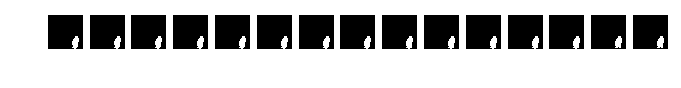

In [1144]:
patched_seg_imgs = [convert_to_rgb(s) for s in pathed_segm[60:]]
show_images_horizontally(patched_seg_imgs)

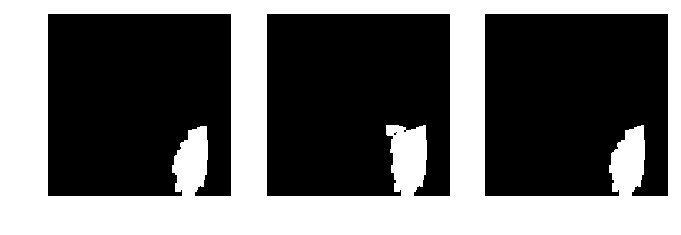

In [1138]:
seg_imgs = [convert_to_rgb(s) for s in test_segm[60:63]]
show_images_horizontally(seg_imgs)

In [953]:
test_vid.display_gif()

In [995]:
segm_problem_video = 's_01_e_08_shot_003729_003803'
# segm_problem_video = 's_02_e_01_shot_030444_030518'
segm_problem_video = 's_06_e_01_shot_009097_009171'
test_vid = get_vid(segm_problem_video)

test_arr_img = np.load(os.path.join(trajectories_dir, frame_arr_dir, test_vid.gid() + '.npy'))
test_frame = test_arr_img[40]
test_char = test_vid.data()['characters'][0]
char_segm = np.load(os.path.join(trajectories_dir, segmentation_dir, test_char.gid() + '_segm.npy.npz'))['arr_0']
# char_bboxes = np.load(os.path.join(trajectories_dir, tracking_dir, test_vid.data()['objects'][0].gid() + '.npy'))

In [996]:
mid_rect = test_char.rect()[1]
mid_segm = char_segm[40]

mid_bbox = create_bbox_segment(scale_box(np.array(mid_rect)))

box_seg_iou = compute_iou(mid_bbox, mid_segm)[0]
box_seg_iou

0.12630961053663242

In [966]:
box_area(np.array(mid_rect).reshape(2, 2))

35400

In [967]:
mid_segm.sum()

241

In [963]:
from anigen_tools.bboxes import box_area

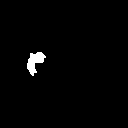

In [958]:
convert_to_rgb(char_segm[40])

In [930]:
ent_area = char_segm.sum(axis=1).sum(axis=1)
med_area = np.median(ent_area)
low_area_thresh = med_area * 0.9
high_area_thresh = med_area * 1.1

good_frames = (high_area_thresh >= ent_area) & (ent_area >= low_area_thresh)

first_good_frame = good_frames.argmax()

patched_ent_masks = np.zeros_like(char_segm)
for fn in range(char_segm.shape[0]):
    if not good_frames[fn]:
        if fn > first_good_frame:
            patched_ent_masks[fn] = patched_ent_masks[fn -1]
        else:
            patched_ent_masks[fn] = char_segm[first_good_frame]
    else:
        patched_ent_masks[fn] = char_segm[fn]

In [931]:
ent_area

array([2158, 2164, 2167, 2164, 2166, 2178, 2177, 2179, 2176, 2160, 2161,
       2110, 2116, 2114, 2117, 2116, 2120, 2100, 2173, 2188, 2094, 2168,
       2184, 2170, 2169, 2166, 2169, 2170, 2185, 2185, 2181, 2119, 2123,
       2120, 2117, 2186, 2178, 2170, 2169, 2169, 2171, 2172, 2172, 2170,
       2170, 2169, 2161, 2162, 2160, 2176, 2175, 2104, 2101, 2118, 2120,
       2140, 2193, 2196, 2209, 2209, 2191, 2194, 2195, 2191, 2193, 2165,
       2165, 2168, 2178, 2097, 2119, 2111, 2107, 2106, 2111], dtype=uint64)

In [932]:
good_frames.sum()

75

In [799]:
low_area_thresh

88.400000000000006

In [710]:
good_frames

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [712]:
os.path.join(trajectories_dir, segmentation_dir, test_char.gid() + '_segm.npy.npz')

'trajectories/improved_segmentation/s_01_e_08_shot_003729_003803_char_0_segm.npy.npz'

In [535]:
np.savez_compressed(os.path.join(trajectories_dir, segmentation_dir, test_char.gid() + '_segm.npy.npz'), patched_ent_masks)
single_frames = draw_video_segmentations(test_vid)

In [557]:
# segm_test_res = draw_video_segmentations(test_vid)

In [14]:
from anigen_tools.hybrid_segmentation import create_bbox_segment, scale_box

In [15]:
tst = create_bbox_segment(scale_box(np.array(test_char.rect()[0])))

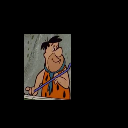

In [58]:
pil.fromarray(img_within_bbox)

In [56]:
img_within_bbox = test_frame * np.tile(np.expand_dims(tst, 2), [1, 1, 3])
gray = cv2.cvtColor(img_within_bbox, cv2.COLOR_RGB2GRAY)
_, threshed = cv2.threshold(gray, 6, 255, cv2.THRESH_BINARY)
new_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
new_thresh = (new_thresh == 0) * tst
new_thresh = new_thresh.astype(np.uint8)

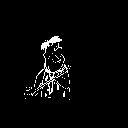

In [172]:
convert_to_rgb(new_thresh)

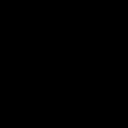

In [142]:
pil.fromarray(threshed > 0 * 19)

In [120]:
black_fg_mask = threshed * tst > 0
black_fg_mask = black_fg_mask.astype(np.uint8)

In [121]:
black_fg_mask.max()

1

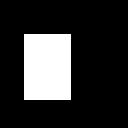

In [122]:
convert_to_rgb(black_fg_mask)

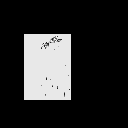

In [98]:
pil.fromarray(threshed* 100)

89248

In [17]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(tst, kernel, iterations = 2)

In [26]:
erosion = cv2.erode(tst, kernel, iterations = 10)

In [409]:
segm_problem_video = 's_01_e_08_shot_003729_003803'
test_vid = get_vid(segm_problem_video)

test_arr_img = np.load(os.path.join(trajectories_dir, frame_arr_dir, test_vid.gid() + '.npy'))
test_frame = test_arr_img[0]
test_char = test_vid.data()['characters'][0]

In [410]:
kernel = np.ones((10,10),np.uint8)

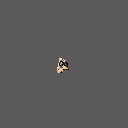

In [774]:
gss, mask = gen_single_segmentation(test_vid, test_char, frame_n=0)
gss

In [412]:
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
masked_ent = test_frame * np.tile(np.expand_dims(mask, 2), [1, 1, 3])

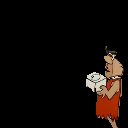

In [413]:
pil.fromarray(masked_ent)

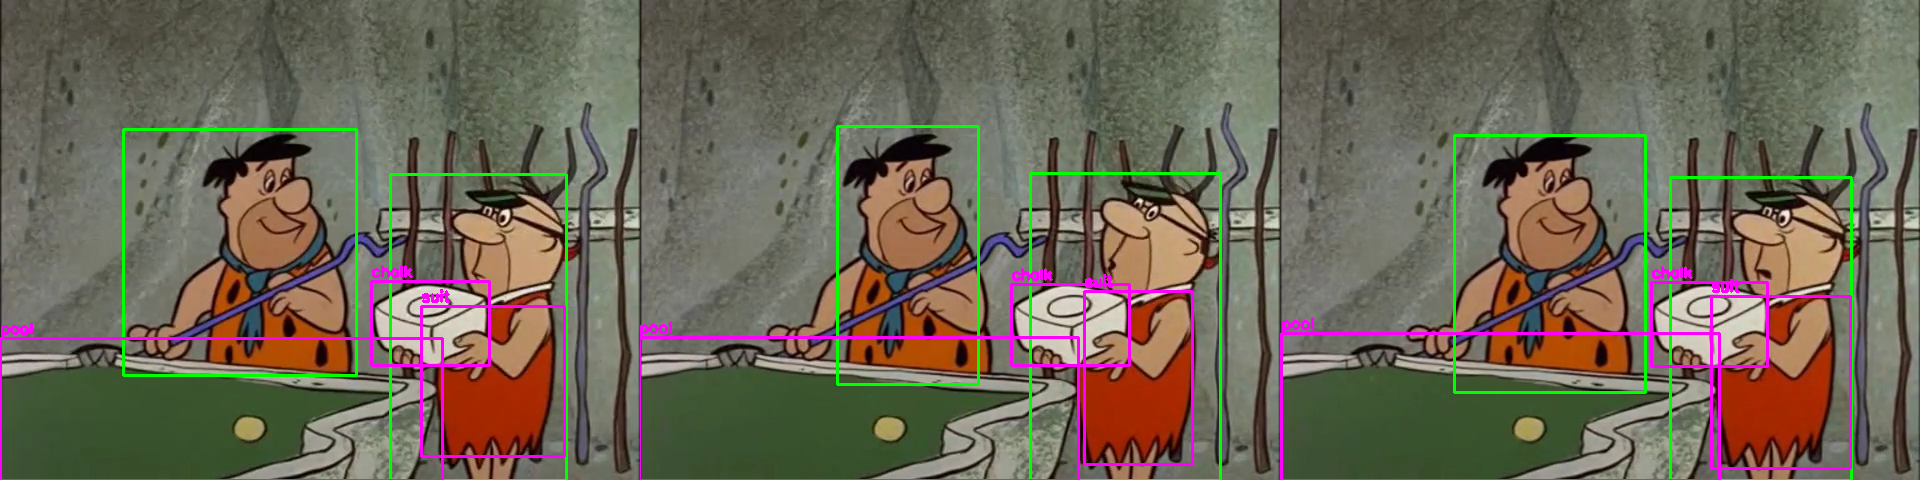

In [854]:
test_vid.display_bounding_boxes()

In [626]:
mask = np.where(char_segm == 1, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')

In [630]:
pd.Series(mask.ravel()).value_counts()

0    1112850
3     115950
dtype: int64

In [570]:
nssm = char_segm[40]

In [571]:
nssm.sum()

1546

In [778]:
draw_video_tracking(test_vid, False)

In [16]:
test_vid.display_gif()

1000


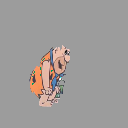

In [32]:
single_seg = gen_single_segmentation(test_vid, test_char, 40)
single_seg

In [19]:
# convert_to_rgb(single_seg)

In [944]:
struct_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
res = cv2.morphologyEx(char_segm, cv2.MORPH_OPEN, struct_kernel)

In [91]:
kernel = np.ones((3,3),np.uint8)

dilation = cv2.dilate(char_segm, kernel, iterations = 2)

In [992]:
kernel = np.ones((3,3),np.uint8)
closed = cv2.morphologyEx(char_segm, cv2.MORPH_CLOSE, kernel)

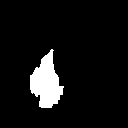

In [994]:
convert_to_rgb(closed[60])

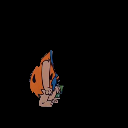

In [1001]:
pil.fromarray(get_vid_frame_data(segm_problem_video)[40] * np.tile(np.expand_dims(char_segm[40], 2), [1, 1, 3]))

In [127]:
draw_video_segmentations(test_vid)

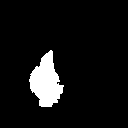

In [997]:
convert_to_rgb(char_segm[40])

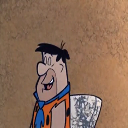

In [805]:
pil.fromarray(test_frame)